# Security Prediction 2

In [48]:
# first we import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import SpatialDropout1D
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

%matplotlib inline

In [83]:
# Getting the spanish stop words
stop = set(stopwords.words("spanish"))

In [2]:
df = pd.read_csv("Gisell.csv")

In [4]:
df.shape

(580, 4)

In [3]:
df.head()

,Antagonismo,Intensidad,Text,Security
0,Nacional,2,"El TLC no sirvió, a México lo incrustaron, ni ...",8
1,Público,2,"Hay más de 80 millones de pobres, se exportan ...",2
2,Nacional,3,"Cedimos la banca nacional, no puedes competir ...",9
3,Interior,2,"No está fluyendo el dinero, se dice que tienen...",5
4,Público,1,Las cajas de ahorro (casi 500) las había cread...,1


### Some Functions

In [5]:
# Lets create some functions
def create_corpus(df, target):
    corpus = []
    for i in df[df["Renaissance"] == target].Text.str.split():
        for j in i:
            corpus.append(j)
    return corpus

# Removing punctuation
def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

# Removing the stopwords
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

def lematizer(text):
    text = [wordnet.lemmatize(word) for word in text.split()]
    return " ".join(text)

In [6]:
df["Antagonismo"].value_counts()

Nacional    427
Interior    133
Público      20
Name: Antagonismo, dtype: int64

In [7]:
df["Intensidad"].value_counts()

2    260
1    168
3    152
Name: Intensidad, dtype: int64

In [8]:
df["Security"].value_counts()

8    198
7    153
9     76
6     68
5     54
4     11
3      8
2      8
1      4
Name: Security, dtype: int64

In [9]:
df["Text"] = df["Text"].map(remove_punct)

In [11]:
df.head()

,Antagonismo,Intensidad,Text,Security
0,Nacional,2,El TLC no sirvió a México lo incrustaron ni si...,8
1,Público,2,Hay más de 80 millones de pobres se exportan 3...,2
2,Nacional,3,Cedimos la banca nacional no puedes competir s...,9
3,Interior,2,No está fluyendo el dinero se dice que tienen ...,5
4,Público,1,Las cajas de ahorro casi 500 las había creado ...,1


In [13]:
df["Text"] = df["Text"].map(lambda x: x.lower())

In [14]:
df.head()

,Antagonismo,Intensidad,Text,Security
0,Nacional,2,el tlc no sirvió a méxico lo incrustaron ni si...,8
1,Público,2,hay más de 80 millones de pobres se exportan 3...,2
2,Nacional,3,cedimos la banca nacional no puedes competir s...,9
3,Interior,2,no está fluyendo el dinero se dice que tienen ...,5
4,Público,1,las cajas de ahorro casi 500 las había creado ...,1


In [15]:
wordnet = WordNetLemmatizer()
corpus = []

In [16]:
# In this case we preserve the stop words since the statements in the Text don't have the length of a full article
df["Text"] = df.Text.apply(lematizer)

In [17]:
df.head()

,Antagonismo,Intensidad,Text,Security
0,Nacional,2,el tlc no sirvió a méxico lo incrustaron ni si...,8
1,Público,2,hay más de 80 millones de pobres se exportan 3...,2
2,Nacional,3,cedimos la banca nacional no puedes competir s...,9
3,Interior,2,no está fluyendo el dinero se dice que tienen ...,5
4,Público,1,la cajas de ahorro casi 500 la había creado ad...,1


In [18]:
# We choose the size of the vocabulary
voc_size = 5_000

In [29]:
X = df.drop(["Antagonismo", "Intensidad", "Security"], axis=1)
y = df["Security"]

In [31]:
# Now we need to append the sentences to one single corpus
for i in range(0, X.shape[0]):
    corpus.append(X["Text"][i])

In [32]:
corpus[0:20]

['el tlc no sirvió a méxico lo incrustaron ni siquiera lo consultaron',
 'hay más de 80 millones de pobres se exportan 30 millones de mexicano por que no hay trabajo',
 'cedimos la banca nacional no puedes competir si no tienes banca el 92 de la banca e extranjera brasil y china le deben su éxito a que su banca en nacional',
 'no está fluyendo el dinero se dice que tienen 180 billones de dólares de reserva pero no se están usando',
 'la cajas de ahorro casi 500 la había creado adriana salina de gortari y quebraron',
 'luego no metieron al aspan asociación de prosperidad y seguridad de norte américa que hizo fox a espaldas de la nación',
 'estamos en un momento sumamente militar',
 'con trump y su política proteccionista ya de facto dice que el modelo neoliberal está muerto',
 'existe una globalización digital que está sustituyendo la globalización mercantilista y la globalización financiera',
 'pareciera que no existen instrumentos ciudadanos de cogobierno en el siglo xxi e decir no po

In [33]:
# One-hot representation, we want the index based on the vocabulary size
onehot_repr = [one_hot(words,voc_size)for words in corpus] 
onehot_repr[0]

[693, 1054, 2372, 591, 4432, 1293, 1219, 1119, 2763, 1586, 1219, 1922]

In [34]:
# EMBEDDING REPRESENTATION
# Making the sentences a fixed length
sent_length = 60
embedded_docs = pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,  693, 1054, 2372,  591, 4432, 1293, 1219,
       1119, 2763, 1586, 1219, 1922], dtype=int32)

In [36]:
y.head()

0    8
1    2
2    9
3    5
4    1
Name: Security, dtype: int64

In [53]:
# Getting dummies for the dependent variable
y = pd.get_dummies(y)
y.head()

,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0


In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(embedded_docs, y.values, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(522, 60) (522, 9)
(58, 60) (58, 9)


In [55]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  364,
       1846, 3406,  693, 1698,  262, 2812, 1633,  489,  693, 3277, 1525,
       4537,  693, 1699,  693,  693], dtype=int32)

In [57]:
Y_train[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8)

In [49]:
# Actually creating the model, first trial
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 40)            200000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 60, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dense (Dense)                (None, 9)                 909       
Total params: 257,309
Trainable params: 257,309
Non-trainable params: 0
_________________________________________________________________
None


## Model Training

In [50]:
from keras.callbacks import EarlyStopping

In [58]:
history = model.fit(X_train, Y_train, validation_split=0.1, epochs=20, batch_size=25, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 469 samples, validate on 53 samples
Epoch 1/20
469/469 [==============================] - 6s 12ms/sample - loss: 2.0299 - accuracy: 0.2985 - val_loss: 1.7863 - val_accuracy: 0.3774
Epoch 2/20
469/469 [==============================] - 2s 5ms/sample - loss: 1.7107 - accuracy: 0.3241 - val_loss: 1.7581 - val_accuracy: 0.1509
Epoch 3/20
469/469 [==============================] - 2s 5ms/sample - loss: 1.7066 - accuracy: 0.3262 - val_loss: 1.7439 - val_accuracy: 0.3774
Epoch 4/20
469/469 [==============================] - 2s 5ms/sample - loss: 1.6845 - accuracy: 0.3348 - val_loss: 1.7119 - val_accuracy: 0.3774
Epoch 5/20
469/469 [==============================] - 2s 5ms/sample - loss: 1.6732 - accuracy: 0.3646 - val_loss: 1.7640 - val_accuracy: 0.1509
Epoch 6/20
469/469 [==============================] - 2s 5ms/sample - loss: 1.6468 - accuracy: 0.3923 - val_loss: 1.6694 - val_accuracy: 0.3774
Epoch 7/20
469/469 [==============================] - 2s 5ms/sample - loss: 1.5992 - accur

In [59]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

58/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

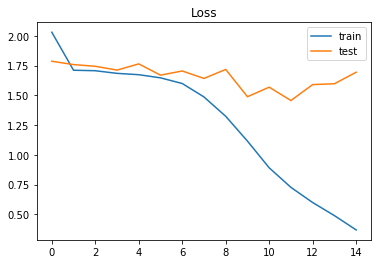

In [60]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

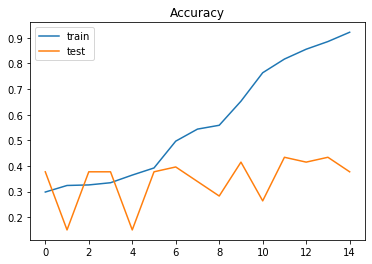

In [72]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## Try a Bidirectional model

In [73]:
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2, activation='relu')))
model.add(Dense(9,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 60, 40)            200000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 60, 40)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1809      
Total params: 314,609
Trainable params: 314,609
Non-trainable params: 0
_________________________________________________________________
None


In [74]:
history = model.fit(X_train, Y_train, validation_split=0.1, epochs=20, batch_size=50, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 469 samples, validate on 53 samples
Epoch 1/20
469/469 [==============================] - 8s 17ms/sample - loss: 2.0994 - accuracy: 0.3134 - val_loss: 1.8735 - val_accuracy: 0.3774
Epoch 2/20
469/469 [==============================] - 2s 5ms/sample - loss: 1.7931 - accuracy: 0.3603 - val_loss: 1.7849 - val_accuracy: 0.1509
Epoch 3/20
469/469 [==============================] - 2s 5ms/sample - loss: 1.7473 - accuracy: 0.2751 - val_loss: 1.7362 - val_accuracy: 0.3208
Epoch 4/20
469/469 [==============================] - 2s 5ms/sample - loss: 1.6962 - accuracy: 0.3198 - val_loss: 1.7286 - val_accuracy: 0.3774
Epoch 5/20
469/469 [==============================] - 2s 5ms/sample - loss: 1.6905 - accuracy: 0.3454 - val_loss: 1.7400 - val_accuracy: 0.3774
Epoch 6/20
469/469 [==============================] - 2s 5ms/sample - loss: 1.6732 - accuracy: 0.3667 - val_loss: 1.7034 - val_accuracy: 0.3774
Epoch 7/20
469/469 [==============================] - 2s 5ms/sample - loss: 1.6528 - accur

In [75]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

58/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

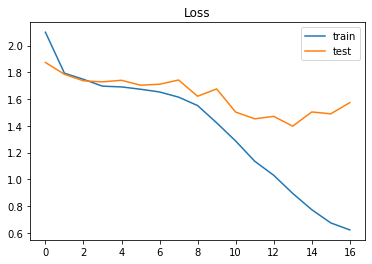

In [76]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

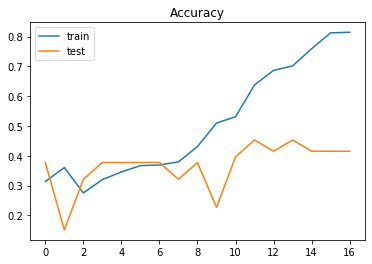

In [77]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## Testing with new statements

**Predict these statements:**
1. "El siguiente año el bitcoin va a seguir subiendo"
2. "México entra en un nacionalismo puro"
3. "2021 será el año de la inflación real"

In [78]:
def preprocess_statement(text):
    statement = remove_punct(text)
    statement = statement.lower()
    statement = remove_stopwords(statement)
    statement = lematizer(statement)
    statement = one_hot(statement, voc_size)
    statement = pad_sequences([statement], padding='pre', maxlen=sent_length)
    return statement

In [80]:
labels = ["Seguridad Pública Nivel 1", 
          "Seguridad Pública Nivel 2",
          "Seguridad Pública Nivel 3",
          "Seguridad Interior Nivel 1",
          "Seguridad Interior Nivel 2",
          "Seguridad Interior Nivel 3",
          "Seguridad Nacional Nivel 1",
          "Seguridad Nacional Nivel 2",
          "Seguridad Nacional Nivel 3"]

In [84]:
pred = model.predict(preprocess_statement("El siguiente año el Bitcoin va a seguir subiendo"))

In [85]:
print(pred, labels[np.argmax(pred)])

[[0.00536262 0.01094743 0.00436418 0.01424189 0.02178924 0.00863544
  0.79123145 0.124068   0.01935972]] Seguridad Nacional Nivel 1


## Second Statement

In [86]:
pred = model.predict(preprocess_statement("México entra en un nacionalismo puro"))
print(pred, labels[np.argmax(pred)])

[[0.0187811  0.0382596  0.0428173  0.05933408 0.29357344 0.1406327
  0.09951944 0.09457801 0.21250428]] Seguridad Interior Nivel 2


## Third Statement

In [87]:
pred = model.predict(preprocess_statement("2021 será el año de la inflación real"))
print(pred, labels[np.argmax(pred)])

[[0.01226279 0.02588269 0.01163873 0.0333868  0.06527083 0.04024188
  0.39116526 0.36367124 0.05647982]] Seguridad Nacional Nivel 1


## Fourth

In [88]:
pred = model.predict(preprocess_statement("Uno de los funcionarios que firmó el pacto por México sigue activo"))
print(pred, labels[np.argmax(pred)])

[[0.01656197 0.03237712 0.03948719 0.05342806 0.29736224 0.18595497
  0.0612279  0.08606134 0.22753918]] Seguridad Interior Nivel 2


## Fifth Statement

In [91]:
pred = model.predict(preprocess_statement("Existen aún muchos muertos a causa del coronavirus"))
print(pred, labels[np.argmax(pred)])

[[0.01872787 0.03845971 0.02812578 0.05579659 0.1536007  0.08542848
  0.31310168 0.17466263 0.13209656]] Seguridad Nacional Nivel 1
